<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/11-training-deep-neural-networks/vanishing_exploding_gradients_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanishing/Exploding Gradients Problems

You may need to train a much deeper DNN, perhaps with 10 layers or many more, each containing hundreds of neurons, linked by hundreds of thousands of connections. Training a deep DNN isn’t a walk in the park. Here are some of the problems you could run into:

* You may be faced with the tricky vanishing gradients problem or the related exploding gradients problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train.
* You might not have enough training data for such a large network, or it might be too costly to label.
* Training may be extremely slow.
* A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if they are too noisy.

## Setup

In [1]:
import sys
assert sys.version_info >= (3, 5)  # Python ≥3.5 is required

import sklearn 
assert sklearn.__version__ >= "0.20"  # Scikit-Learn ≥0.20 is required

# %tensorflow_version only exists in Colab.
try:
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= '2.0'

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

TensorFlow 2.x selected.


## Vanishing/Exploding Gradients Problem

Unfortunately, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers’ connection weights virtually unchanged, and training never converges to a good solution. We call this the vanishing gradients problem. 

In some cases, the opposite can happen: the gradients can grow bigger and bigger until layers get insanely large weight updates and the algorithm diverges. This is the exploding gradients problem, which surfaces in recurrent neural networks.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000s. It wasn’t clear what caused the gradients to be so unstable when training a DNN, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. 

The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e., a normal distribution with a mean of 0 and a standard deviation of 1). In short, they showed that with this activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs. 

Going forward in the network, the variance keeps increasing after each layer until the activation function saturates at the top layers. This saturation is actually made worse by the fact that the logistic function has a mean of 0.5, not 0 (the hyperbolic tangent function has a mean of 0 and behaves slightly better than the logistic function in deep networks).

### Logistic activation function saturation

Looking at the logistic activation function, you can see that when inputs become large (negative or positive), the function saturates at 0 or 1, with a derivative extremely close to 0. Thus, when backpropagation kicks in it has virtually no gradient to propagate back through the network; and what little gradient exists keeps getting diluted as backpropagation progresses down through the top layers,so there is really nothing left for the lower layers.

In [0]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

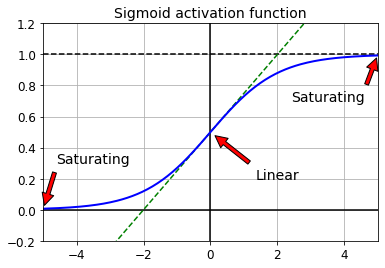

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')         # lower solid black line
plt.plot([-5, 5], [1, 1], 'k--')        # upper dashed black line

plt.plot([0, 0], [-0.2, 1.2], 'k-')     # zero divider black line
plt.plot([-5, 5], [-3/4, 7/4], 'g--')   # green dashed line

plt.plot(z, sigmoid(z), 'b-', linewidth=2)

props = dict(facecolor='red', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')

plt.grid(True)
plt.title('Sigmoid activation function', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### Glorot and He Initialization

Glorot and Bengio propose a way to significantly alleviate the unstable gradients problem. They point out that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don’t want the signal to die out, nor do we want it to explode and saturate. 

For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, 2 and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction.

is actually not possible to guarantee both unless the layer has an equal number of inputs and neurons (these numbers are called the fan-in and fan-out of the layer), but Glorot and Bengio proposed a good compromise that has proven to work very well in practice: the connection weights of each layer must be initialized randomly.

This initialization strategy is called Xavier initialization or Glorot initialization , after the paper’s first author.

By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal" like this:

In [4]:
[name for name in dir(keras.initializers) if not name.startswith('_')]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

In [5]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

If you want He initialization with a uniform distribution but based on fan avg rather than fan in , you can use the VarianceScaling initializer like this:

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

### Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation function. Until then most people had assumed that if Mother Nature had chosen to use roughly sigmoid activation functions in biological neurons, they must be an excellent choice. But it turns out that other activation functions behave much better in deep neural networks—in particular, the ReLU activation function, mostly because it does not saturate for positive values (and because it is fast to compute).

Unfortunately, the ReLU activation function is not perfect. It suffers from a problem known as the dying ReLUs : during training, some neurons effectively “die,” meaning they stop outputting anything other than 0. 

In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. 

A neuron dies when its weights get tweaked in such a way that the weighted sum of its inputs are negative for all instances in the training set. When this happens, it just keeps outputting zeros, and Gradient Descent does not affect it anymore because the gradient of the ReLU function is zero when its input is negative.

#### LeakyReLU

To solve this problem, you may want to use a variant of the ReLU function, such as the leaky ReLU . This function is defined as LeakyReLU α(z) = max(αz,z). The hyperparameter α defines how much the function “leaks”: it is the slope of the function for z < 0 and is typically set to 0.01. This small slope ensures that leaky ReLUs never die; they can go into a long coma, but they have a chance to eventually wake up.

In [0]:
def leaky_relu(z, alpha=0.01):
  return np.maximum(alpha * z, z)

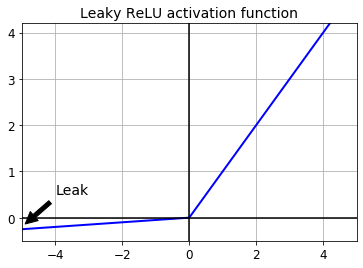

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
[name for name in dir(keras.activations) if not name.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [0]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [0]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation='softmax')
])

In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 152us/sample - loss: 1.2806 - accuracy: 0.6250 - val_loss: 0.8882 - val_accuracy: 0.7150
Epoch 2/10
55000/55000 [==============================] - 8s 147us/sample - loss: 0.7954 - accuracy: 0.7373 - val_loss: 0.7135 - val_accuracy: 0.7648
Epoch 3/10
55000/55000 [==============================] - 8s 149us/sample - loss: 0.6816 - accuracy: 0.7726 - val_loss: 0.6355 - val_accuracy: 0.7882
Epoch 4/10
55000/55000 [==============================] - 8s 138us/sample - loss: 0.6215 - accuracy: 0.7935 - val_loss: 0.5922 - val_accuracy: 0.8010
Epoch 5/10
55000/55000 [==============================] - 7s 135us/sample - loss: 0.5830 - accuracy: 0.8082 - val_loss: 0.5596 - val_accuracy: 0.8170
Epoch 6/10
55000/55000 [==============================] - 7s 129us/sample - loss: 0.5553 - accuracy: 0.8155 - val_loss: 0.5339 - val_accuracy: 0.8238
Epoch 7/10
55000/55000 [===========================

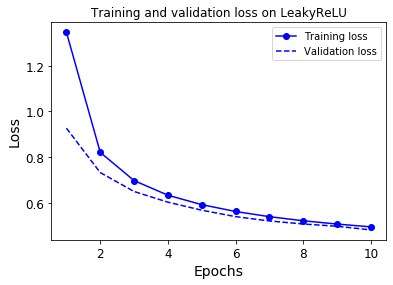

In [23]:
# Plotting the training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on LeakyReLU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### PReLU

Finally, the paper evaluated the parametric leaky ReLU (PReLU), where α is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.

Now let's try PReLU:

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy'])
history_1 = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 9s 165us/sample - loss: 1.3470 - accuracy: 0.6225 - val_loss: 0.9268 - val_accuracy: 0.7200
Epoch 2/10
55000/55000 [==============================] - 9s 161us/sample - loss: 0.8208 - accuracy: 0.7357 - val_loss: 0.7322 - val_accuracy: 0.7640
Epoch 3/10
55000/55000 [==============================] - 8s 152us/sample - loss: 0.6972 - accuracy: 0.7697 - val_loss: 0.6494 - val_accuracy: 0.7868
Epoch 4/10
55000/55000 [==============================] - 9s 158us/sample - loss: 0.6332 - accuracy: 0.7904 - val_loss: 0.6027 - val_accuracy: 0.8024
Epoch 5/10
55000/55000 [==============================] - 9s 156us/sample - loss: 0.5918 - accuracy: 0.8051 - val_loss: 0.5675 - val_accuracy: 0.8140
Epoch 6/10
55000/55000 [==============================] - 8s 152us/sample - loss: 0.5619 - accuracy: 0.8140 - val_loss: 0.5393 - val_accuracy: 0.8252
Epoch 7/10
55000/55000 [===========================

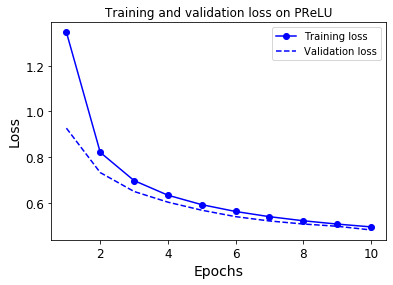

In [24]:
# Plotting the training and validation loss
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on PReLU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### SELU

New activation function called the exponential linear unit (ELU) that outperformed all the ReLU variants in the authors’ experiments: training time was reduced, and the neural network performed better on the test set.

In [0]:
def elu(z, alpha=1):
  return np.where(z < 0, alpha * (np.exp(z) -1), z)

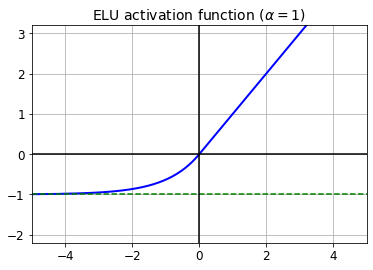

In [27]:
plt.plot(z, elu(z), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'g--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r'ELU activation function ($\alpha=1$)', fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [30]:
tf.random.set_seed(42)
np.random.seed(42)

model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax')
])

model_2.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy'])
history_2 = model_2.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 8s 141us/sample - loss: 1.1190 - accuracy: 0.6485 - val_loss: 0.7916 - val_accuracy: 0.7386
Epoch 2/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.7224 - accuracy: 0.7569 - val_loss: 0.6573 - val_accuracy: 0.7834
Epoch 3/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.6315 - accuracy: 0.7886 - val_loss: 0.5937 - val_accuracy: 0.8044
Epoch 4/10
55000/55000 [==============================] - 7s 128us/sample - loss: 0.5822 - accuracy: 0.8054 - val_loss: 0.5583 - val_accuracy: 0.8152
Epoch 5/10
55000/55000 [==============================] - 7s 130us/sample - loss: 0.5507 - accuracy: 0.8139 - val_loss: 0.5311 - val_accuracy: 0.8262
Epoch 6/10
55000/55000 [==============================] - 7s 132us/sample - loss: 0.5281 - accuracy: 0.8205 - val_loss: 0.5103 - val_accuracy: 0.8300
Epoch 7/10
55000/55000 [===========================

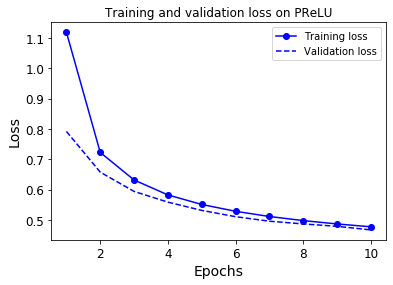

In [31]:
# Plotting the training and validation loss
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on PReLU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### SELU

Günter Klambauer et al. introduced the Scaled ELU (SELU) activation function: as its name suggests, it is a scaled variant of the ELU activation function.

If you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will self-normalize : the output of each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. 

As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones). There are, however, a few conditions for self-normalization to happen (see the paper for the mathematical justification):

* The input features must be standardized (mean 0 and standard deviation 1).
* Every hidden layer’s weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer="lecun_normal" .
* The network’s architecture must be sequential. Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e., connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.
* The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well.



In [0]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 
+ np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [0]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
  return scale * elu(z, alpha)

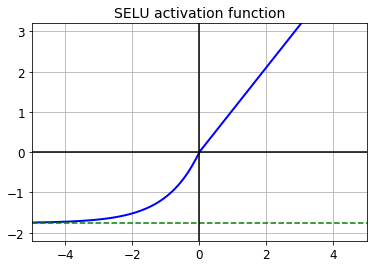

In [34]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'g--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [37]:
np.random.seed(42)

Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
  W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100))   # LeCun initialization
  Z = selu(np.dot(Z, W))
  means = np.mean(Z, axis=0).mean()
  stds = np.std(Z, axis=0).mean()
  if layer % 100 == 0:
    print(f'Layer {str(layer)}: mean {str(means)}, std deviation {str(stds)}')

Layer 0: mean -0.0018323191229082008, std deviation 0.9993326848140984
Layer 100: mean 0.022381401728658233, std deviation 0.9624307594850076
Layer 200: mean 0.009595136169400253, std deviation 0.9044881262732791
Layer 300: mean -0.01519457019455962, std deviation 0.9236924543338303
Layer 400: mean 0.05413433801497661, std deviation 0.891602836975457
Layer 500: mean 0.005853113037170003, std deviation 0.9286462935545744
Layer 600: mean 0.022268621656531477, std deviation 0.9166416317851165
Layer 700: mean -0.01825918849256755, std deviation 0.9033546354839294
Layer 800: mean 0.05381074844549197, std deviation 0.8250118130851406
Layer 900: mean 0.019907971909592856, std deviation 0.9955889510480945


Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

model_3 = keras.Sequential()
model_3.add(keras.layers.Flatten(input_shape=[28, 28]))
model_3.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))

for layer in range(99):
  model_3.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model_3.add(keras.layers.Dense(10, activation='softmax'))

model_3.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy'])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [40]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history_3 = model_3.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 61s 1ms/sample - loss: 1.0594 - accuracy: 0.5887 - val_loss: 0.7304 - val_accuracy: 0.7420
Epoch 2/5
55000/55000 [==============================] - 51s 920us/sample - loss: 0.6942 - accuracy: 0.7493 - val_loss: 0.6293 - val_accuracy: 0.7698
Epoch 3/5
55000/55000 [==============================] - 52s 951us/sample - loss: 0.5916 - accuracy: 0.7864 - val_loss: 0.6182 - val_accuracy: 0.7938
Epoch 4/5
55000/55000 [==============================] - 52s 951us/sample - loss: 0.5829 - accuracy: 0.7936 - val_loss: 0.5710 - val_accuracy: 0.8074
Epoch 5/5
55000/55000 [==============================] - 54s 974us/sample - loss: 0.5826 - accuracy: 0.7885 - val_loss: 0.5712 - val_accuracy: 0.7996


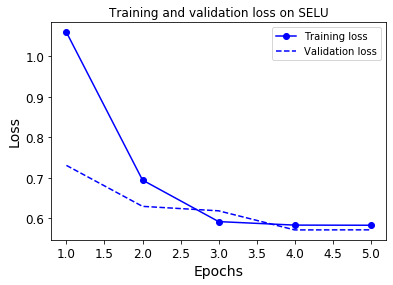

In [41]:
# Plotting the training and validation loss
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on SELU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Now look at what happens if we try to use the ReLU activation function instead:

In [42]:
np.random.seed(42)
tf.random.set_seed(42)

model_4 = keras.Sequential()
model_4.add(keras.layers.Flatten(input_shape=[28, 28]))
model_4.add(keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))

for layer in range(99):
  model_4.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model_4.add(keras.layers.Dense(10, activation='softmax'))

model_4.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['accuracy'])
history_4 = model_4.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 39s 702us/sample - loss: 1.7524 - accuracy: 0.2946 - val_loss: 1.1445 - val_accuracy: 0.5586
Epoch 2/5
55000/55000 [==============================] - 34s 620us/sample - loss: 1.0957 - accuracy: 0.5587 - val_loss: 0.9780 - val_accuracy: 0.5942
Epoch 3/5
55000/55000 [==============================] - 34s 614us/sample - loss: 1.0329 - accuracy: 0.5788 - val_loss: 0.8444 - val_accuracy: 0.6646
Epoch 4/5
55000/55000 [==============================] - 34s 611us/sample - loss: 0.8915 - accuracy: 0.6484 - val_loss: 0.8008 - val_accuracy: 0.6740
Epoch 5/5
55000/55000 [==============================] - 34s 611us/sample - loss: 0.7790 - accuracy: 0.7103 - val_loss: 0.7376 - val_accuracy: 0.7236


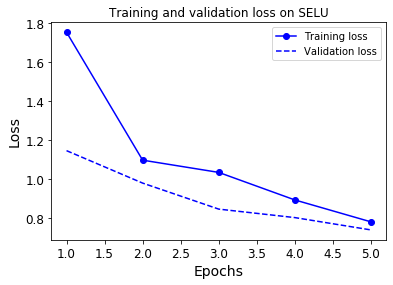

In [43]:
# Plotting the training and validation loss
loss = history_4.history['loss']
val_loss = history_4.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss on SELU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Not great at all, we suffered from the vanishing/exploding gradients problem.

## Batch Normalization